In [1]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
import keras
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D , InputLayer,Dense ,Flatten, BatchNormalization

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy,FalsePositives,FalseNegatives, Precision, AUC ,Recall,TruePositives ,TrueNegatives
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer,Dropout
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

import cv2
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator   # for lebelling images
from tensorflow.keras.preprocessing import image


from tensorboard.plugins.hparams import api as hp

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model


In [10]:

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Vaisualization of data

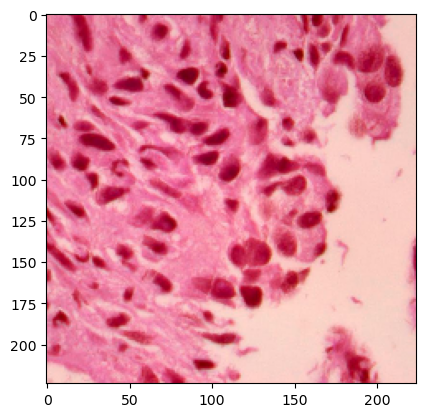

In [11]:
image_1 = cv2.resize(cv2.imread('/Users/harshalrajput/Desktop/Tensorflow/dataset/test_set/lung_aca/lungaca4001.jpeg'), (224,224))
plt.imshow(image_1)

In [12]:
cv2.imread('/Users/harshalrajput/Desktop/Tensorflow/dataset/test_set/lung_aca/lungaca4001.jpeg').shape

(768, 768, 3)

In [3]:
# creating labels for images 

train = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)
test = ImageDataGenerator(rescale = 1/255)

In [13]:
train_dataset[1]

(array([[[[0.91372555, 0.8196079 , 0.8117648 ],
          [0.9176471 , 0.8235295 , 0.8235295 ],
          [0.89019614, 0.79215693, 0.80392164],
          ...,
          [0.6627451 , 0.34509805, 0.7058824 ],
          [0.7058824 , 0.40784317, 0.7607844 ],
          [0.7294118 , 0.43921572, 0.78823537]],
 
         [[0.9058824 , 0.8117648 , 0.80392164],
          [0.91372555, 0.8196079 , 0.8196079 ],
          [0.909804  , 0.8117648 , 0.8235295 ],
          ...,
          [0.6745098 , 0.36078432, 0.69411767],
          [0.7137255 , 0.41960788, 0.7411765 ],
          [0.75294125, 0.47058827, 0.7686275 ]],
 
         [[0.9058824 , 0.8117648 , 0.80392164],
          [0.9176471 , 0.8235295 , 0.8235295 ],
          [0.91372555, 0.81568635, 0.82745105],
          ...,
          [0.6745098 , 0.3647059 , 0.6901961 ],
          [0.7137255 , 0.42352945, 0.7254902 ],
          [0.7372549 , 0.45882356, 0.7254902 ]],
 
         ...,
 
         [[0.8431373 , 0.5803922 , 0.7803922 ],
          [0.82745

In [6]:
# importing all data from folders using path and dividing into batches and reshaping
# class_mode catagorical as more than two classes are there 0,1,2

train_dataset = train.flow_from_directory('/Users/harshalrajput/Desktop/Tensorflow/dataset/training_set',
                                         target_size = (224,224),
                                          batch_size = 30,
                                         class_mode = 'categorical')

val_dataset = train.flow_from_directory('/Users/harshalrajput/Desktop/Tensorflow/dataset/validation_set',
                                         target_size = (224,224),
                                          batch_size = 30,
                                         class_mode = 'categorical')

test_dataset = train.flow_from_directory('/Users/harshalrajput/Desktop/Tensorflow/dataset/test_set',
                                         target_size = (224,224),
                                          batch_size = 30,
                                         class_mode = 'categorical')

Found 9003 images belonging to 3 classes.
Found 2997 images belonging to 3 classes.
Found 2997 images belonging to 3 classes.


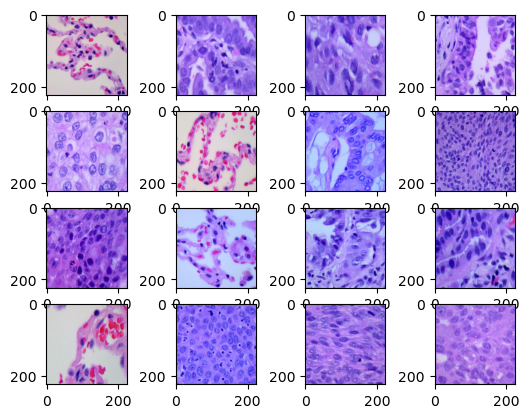

In [15]:
for i, (image,label) in enumerate(train_dataset):
    
    if i <= 15:  # 0 - to 15  = 16 images (4,4,i+1)
        
        plt.subplot(4,4,i+1)
        img = np.resize(image, (224,224,3))

        img = np.float32(img) # converting image to float 
        plt.imshow(img)
    else:
        break

In [16]:
train_dataset.class_indices

{'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}

In [17]:
train_dataset.classes  

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [18]:
val_dataset.class_indices

{'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}

# Creating model using VGG16

In [19]:
vgg16 = VGG16(input_shape = [224,224,3], weights = 'imagenet', include_top = False )

# include_top = False tells us not to include 1st and last layer as 1st layer bacause resizing and last for predicting

2023-11-18 11:10:45.734893: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-18 11:10:45.734948: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-18 11:10:45.734951: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-18 11:10:45.734999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-18 11:10:45.735028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
for layer in vgg16.layers:
    layer.trainable = False
# weights should not change throught the layers in vgg16 , weights will chage in last layer i.e prediction layer   

In [21]:
x = Flatten()(vgg16.output)  # flatten for all extracted features

In [22]:
prediction = Dense(3,activation = 'softmax')(x) # last layer  

In [23]:
model = Model(inputs = vgg16.input, outputs = prediction)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
metrics = [BinaryAccuracy (name= 'accuracy'), Precision(name='precision'),
           Recall(name= 'recall')]

In [26]:
# callback for saving your losses , metrics in csv

csv_callback = CSVLogger('csv_logger_cancer',
                         separator = ',', append = False)

In [27]:
# tensorboard callback for visualizing using model performance

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="logs/"
)


In [28]:
# early callback for stopping your model when val_loss will not be reduced for for 3 subsequent epochs

early_callback = EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                                   patience = 3, verbose = 1, mode = 'auto',baseline = None,
                                                 restore_best_weights = False )

In [29]:
model.compile(loss = BinaryCrossentropy(),optimizer = Adam(learning_rate = 0.01), metrics = metrics)

In [30]:
history = model.fit_generator(train_dataset, validation_data  = val_dataset, epochs = 10, 
                    verbose = 1, callbacks = [csv_callback,tensorboard_callback,early_callback])

Epoch 1/10


2023-11-18 11:11:01.997727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


301/301 [==============================] - 200s 657ms/step - loss: 0.4503 - accuracy: 0.9466 - precision: 0.9199 - recall: 0.9199 - val_loss: 0.1469 - val_accuracy: 0.9760 - val_precision: 0.9640 - val_recall: 0.9640
Epoch 2/10
301/301 [==============================] - 221s 735ms/step - loss: 0.1090 - accuracy: 0.9841 - precision: 0.9761 - recall: 0.9761 - val_loss: 0.1501 - val_accuracy: 0.9751 - val_precision: 0.9626 - val_recall: 0.9626
Epoch 3/10
301/301 [==============================] - 314s 1s/step - loss: 0.0988 - accuracy: 0.9866 - precision: 0.9799 - recall: 0.9799 - val_loss: 0.2319 - val_accuracy: 0.9804 - val_precision: 0.9706 - val_recall: 0.9706
Epoch 4/10
301/301 [==============================] - 405s 1s/step - loss: 0.0354 - accuracy: 0.9955 - precision: 0.9932 - recall: 0.9932 - val_loss: 0.1815 - val_accuracy: 0.9746 - val_precision: 0.9620 - val_recall: 0.9620
Epoch 4: early stopping


In [56]:
%load_ext tensorboard

# run %tensorboard --logdir (path for logs file in your folder)     in your command prompt to see visuals

In [31]:
len(tf.config.list_physical_devices('GPU'))

1

# Visualizing model performance

In [ ]:
# All these graphs you will get to see in tensorboard

In [57]:
print(history.history)

{'loss': [0.1313348114490509, 0.12119916826486588, 0.05279862508177757, 0.038552019745111465, 0.045583292841911316, 0.035886529833078384], 'accuracy': [0.9705653786659241, 0.9813395738601685, 0.9907808303833008, 0.995445966720581, 0.9943352341651917, 0.9963345527648926], 'val_loss': [0.2475326955318451, 0.1939566731452942, 0.10289707779884338, 0.10427495837211609, 0.15332640707492828, 0.11916504055261612], 'val_accuracy': [0.9673006534576416, 0.9606273174285889, 0.9799799919128418, 0.9789789915084839, 0.9683016538619995, 0.977977991104126]}


Text(0, 0.5, 'loss')

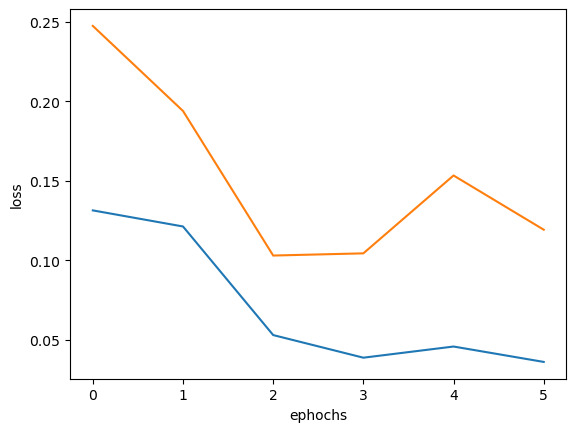

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('ephochs')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

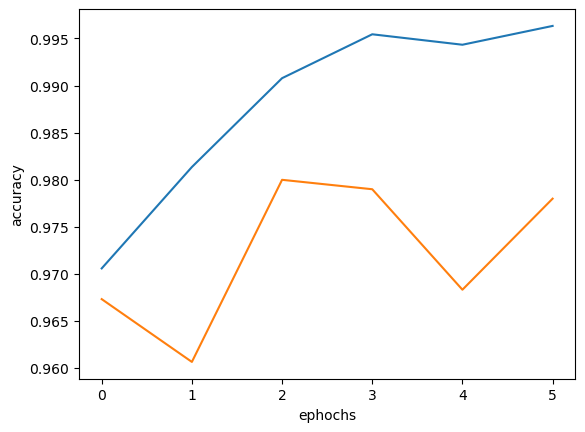

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('ephochs')
plt.ylabel('accuracy')

In [14]:
a = model.predict(test_dataset)

2023-10-30 10:11:06.269389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 47s 461ms/step


In [15]:
a   # greter the value for particular class

array([[0.26169503, 0.51486975, 0.2234352 ],
       [0.40611258, 0.29399326, 0.2998942 ],
       [0.31178117, 0.36652192, 0.32169694],
       ...,
       [0.3591305 , 0.22387931, 0.41699013],
       [0.39042756, 0.27467522, 0.3348972 ],
       [0.3717826 , 0.28442   , 0.3437974 ]], dtype=float32)

In [24]:
imp = image.load_img('/Users/harshalrajput/Desktop/Tensorflow/dataset/test_set/lung_scc/lungscc4001.jpeg', 
                     target_size = (224,224))

In [27]:
imp = tf.cast(imp,tf.float32)


In [29]:
imp.dtype

tf.float32

In [17]:
x = image.img_to_array(imp)
x

array([[[181., 131., 230.],
        [162., 111., 216.],
        [171., 120., 225.],
        ...,
        [158., 120., 221.],
        [161., 121., 233.],
        [168., 131., 227.]],

       [[150., 108., 210.],
        [149., 106., 211.],
        [154., 111., 216.],
        ...,
        [174., 136., 237.],
        [168., 131., 234.],
        [186., 155., 233.]],

       [[140., 101., 210.],
        [149., 110., 217.],
        [141., 102., 208.],
        ...,
        [166., 126., 225.],
        [170., 134., 234.],
        [190., 162., 236.]],

       ...,

       [[ 86.,  44., 182.],
        [ 82.,  41., 182.],
        [ 80.,  41., 182.],
        ...,
        [172., 138., 215.],
        [177., 137., 223.],
        [161., 115., 213.]],

       [[ 77.,  36., 177.],
        [ 75.,  36., 181.],
        [ 78.,  41., 183.],
        ...,
        [170., 135., 215.],
        [178., 140., 225.],
        [167., 126., 220.]],

       [[ 88.,  49., 190.],
        [ 92.,  55., 197.],
        [ 91.,  

In [19]:
x = x/255

In [20]:
x = np.expand_dims(x, axis = 0)
# imp_data = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [22]:
pred = np.argmax(model.predict(x), axis = 1)
pred

1/1 [==============================] - 0s 22ms/step


array([2])

In [23]:
if pred == 0:
    print('class 1')
elif pred == 1:
    print('class 2')
else:
    print('class 3')

class 3


# Building model manually

In [66]:
model = tf.keras.Sequential([
    
                    Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)) , # conv layer 1
                    BatchNormalization(),
                    MaxPool2D(pool_size=2, strides = 2),                                                      # pooling layer 1
                    
                    Conv2D(filters =32,kernel_size = 2,strides=(1, 1),padding='same', activation = 'relu'),  # conv layer 2
                    BatchNormalization(),
                    MaxPool2D(pool_size = 2, strides = 2),    # pooling layer 2
                   
                    Conv2D(filters =64,kernel_size = 2,strides=(1, 1),padding='same', activation = 'relu'),  # conv layer 2
                    BatchNormalization(),
                    MaxPool2D(pool_size = 2, strides = 2),
                     
# above layer for extracting features from image     
                              
                    Flatten(),   # flatten layer convert into one d array
                             
# below layer are for classifieng image
                    Dense(500, activation = 'relu'),
                    Dense(3, activation = 'softmax'),
                    
                    
    ]) 




In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      208       
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 batch_normalization_2 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                        

In [73]:
model.compile(loss = BinaryCrossentropy(),optimizer = Adam(learning_rate = 0.01), metrics = metrics)

In [74]:
history = model.fit_generator(train_dataset, validation_data  = val_dataset, epochs = 10, 
                    verbose = 1, callbacks = [csv_callback,tensorboard_callback,early_callback])

Epoch 1/10
301/301 [==============================] - 62s 188ms/step - loss: 495.0567 - accuracy: 0.8641 - precision: 0.7962 - recall: 0.7961 - val_loss: 8573.0928 - val_accuracy: 0.6654 - val_precision: 0.4982 - val_recall: 0.4982
Epoch 2/10
301/301 [==============================] - 51s 169ms/step - loss: 7861.6177 - accuracy: 0.8772 - precision: 0.8158 - recall: 0.8158 - val_loss: 93126.4375 - val_accuracy: 0.7649 - val_precision: 0.6473 - val_recall: 0.6473
Epoch 3/10
301/301 [==============================] - 55s 183ms/step - loss: 17882.7598 - accuracy: 0.8889 - precision: 0.8333 - recall: 0.8333 - val_loss: 109969.1172 - val_accuracy: 0.7242 - val_precision: 0.5863 - val_recall: 0.5863
Epoch 4/10
301/301 [==============================] - 58s 192ms/step - loss: 30926.6504 - accuracy: 0.8903 - precision: 0.8354 - recall: 0.8354 - val_loss: 97264.6172 - val_accuracy: 0.8485 - val_precision: 0.7728 - val_recall: 0.7728
Epoch 4: early stopping


Text(0, 0.5, 'loss')

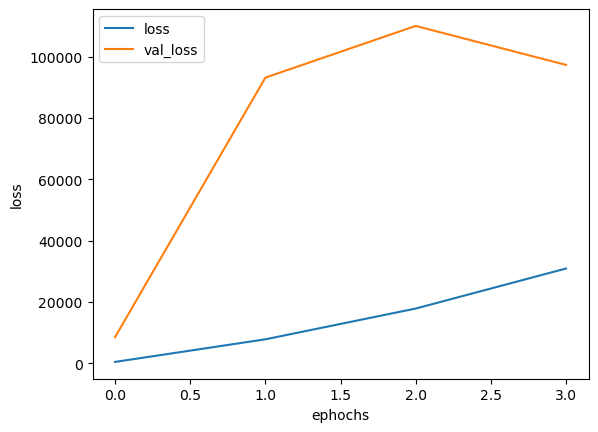

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('ephochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

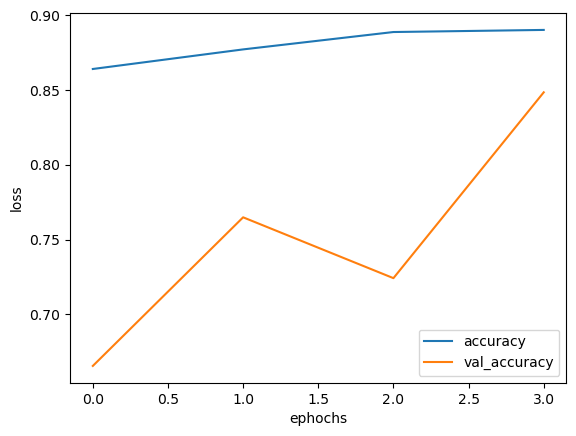

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('ephochs')
plt.ylabel('loss')

# Hyperparameter tunning

In [ ]:
# Avoid this step as it could required more time to execute

In [55]:
def model_tunning(hparams):
    

        model = tf.keras.Sequential([
                 
                    InputLayer(input_shape = (IMP_SIZE,IMP_SIZE,3)),
                                     
                     
                    Conv2D(filters =16,kernel_size = 3,kernel_regularizer = L2(hparams[hp_regularizer_rate]),strides=(1, 1),padding='same', activation = 'relu'),                 
                    MaxPool2D(pool_size = 2, strides = 2),                                                      # pooling layer 1
                    Dropout(rate = hparams[HP_droput]),
                             
                    Conv2D(filters =32,kernel_size = 3,kernel_regularizer = L2(hparams[hp_regularizer_rate]),strides=(1, 1),padding='same', activation = 'relu' ),  # conv layer 2
                    BatchNormalization(),
                    MaxPool2D(pool_size = 2, strides = 2),    # pooling layer 2
                     
# above layer for extracting features from image     
                              
                    Flatten(),   # flatten layer convert into one d array
                             
# below layer are for classifieng image
                    Dense(hparams[hp_neuron1],kernel_regularizer = L2(hparams[hp_regularizer_rate]), activation = 'relu'),
                    BatchNormalization(),
                    Dropout(rate = hparams[HP_droput]),
                    Dense(3, activation = 'softmax')  
        ])

                    
        
 

        model.compile(loss = BinaryCrossentropy(),optimizer = Adam(learning_rate = hparams[hp_learning_rate]), metrics = 'accuracy')
        model.fit(val_dataset,epochs = 1)
        _,accuracy = model.evaluate(val_dataset)
        return accuracy
                          


In [ ]:
HP_droput = hp.HParam('dropout', hp.Discrete([0.1,0.2,0.3]))
# hp_avtivation = hp.HParam('avtivation', hp.Discrete(['softmax','relu','tanh']))
hp_neuron1 = hp.HParam('neuron1', hp.Discrete([16,32,64,128]))
hp_neuron2 = hp.HParam('neuron2', hp.Discrete([16,32,64,128]))
hp_regularizer_rate = hp.HParam('regularization_rate', hp.Discrete([0.1,0.01,0.001]))
hp_learning_rate = hp.HParam('learning_rate', hp.Discrete([0.1,0.01,0.001]))
# hp_epochs = hp.HParam('epochs', hp.Discrete([10,50,100]))



In [ ]:
# it could take 6 to 8 hr depending on your computer processor

In [ ]:
run_number = 0

for dropout in HP_droput.domain.values:
    
        
#     for avtivation in hp_avtivation.domain.values:
        for neuron1 in hp_neuron1.domain.values:
            for neuron2 in hp_neuron2.domain.values:
                for regularization_rate in hp_regularizer_rate.domain.values:
                    for learning_rate in hp_learning_rate.domain.values:
#                         for epochs in hp_epochs.domain.values:
                        
                        
                     hparams = {    # dict for hyperparameter tunning
                             
                            HP_droput : dropout,
#                             hp_avtivation : avtivation,
                            hp_neuron1 : neuron1,
                            hp_neuron2 : neuron2,
                            hp_regularizer_rate : regularization_rate,
                            hp_learning_rate : learning_rate,
                            hp_epochs : epochs
                            }
                        
                     file_writer= tf.summary.create_file_writer('log?/' + str(run_number))
                        
                        
                        
                        
                    with file_writer.as_default():
                            hp.hparams(hparams)
                            accuracy = model_tunning(hparams)
                            tf.summary.scalar('accuracy', accuracy, step =0) 
                        
                    print('For the run {} : Our hparams dropou:{}, neuron1:{} , neuron2:{}, learning_rate:{}, regularization_rate:{} '.format(run_number,
                        hparams[HP_droput],hparams[hp_neuron1],hparams[hp_neuron2],hparams[hp_learning_rate], hparams[hp_regularizer_rate]))
                        
                    run_number = run_number +1
                     
        
        
    

# Model saving and loading

In [12]:
from tensorflow.keras.models import load_model   # for saving model

model.save('cancer_model.h5')

In [2]:
from tensorflow.keras.models import load_model
model = load_model('cancer_model.h5')

In [3]:
model = load_model('cancer_model.h5')  #model loading

2023-11-01 11:25:48.034751: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-01 11:25:48.034777: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-01 11:25:48.034781: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-01 11:25:48.035020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-01 11:25:48.035403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
